In [5]:
import pandas as pd
from merlion.utils import TimeSeries

# 加载数据
air_pass = pd.read_csv("data/airline-passengers.csv")
# 把日期设置为索引
air_pass.set_index('Month', inplace=True)
air_pass.index = pd.to_datetime(air_pass.index)
# 一定要确保freq设定好
air_pass.index.freq = 'MS'

# 读取为TimeSeries对象
air_pass_ts = TimeSeries.from_pd(air_pass, freq='MS')
print(air_pass_ts.is_aligned)

# 使用 .bisect() 函数切分数据为训练集和测试集
# 我们希望预估未来6个月的乘客量
air_pass_ts_train, air_pass_ts_test = air_pass_ts.bisect('1960-07-01')

True


In [6]:
# 使用lgbm和autosarima两个方法
from merlion.models.forecast.trees import LGBMForecaster, LGBMForecasterConfig
from merlion.models.automl.autosarima import AutoSarima, AutoSarimaConfig
# 使用集成技术
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig
# 通过评估指标来选择模型
from merlion.evaluate.forecast import ForecastMetric
# 定义模型
lgbm_config = LGBMForecasterConfig(maxlags = 5, max_forecast_steps=len(air_pass_ts_test))
lgbm = LGBMForecaster(lgbm_config)
sarima_config = AutoSarimaConfig(auto_pqPQ=True, auto_d=True, auto_D=True, auto_seasonality=True, approximation=True, maxiter=5)
sarima = AutoSarima(sarima_config)
# 通过sMAPE指标选择最佳模型
selector_config = ForecasterEnsembleConfig(
    combiner=ModelSelector(metric=ForecastMetric.sMAPE))
selector = ForecasterEnsemble(
    config=selector_config, models=[lgbm, sarima])
selector.train(air_pass_ts_train)
selector.forecast(air_pass_ts_test.time_stamps)

Inferred granularity <MonthBegin>
Inferred granularity <MonthBegin>


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 5
[LightGBM] [Info] Start training from score 237.933333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

ForecastEvaluator: 100%|██████████| 71107200/71107200 [00:00<00:00, 619156508.23it/s]
Inferred granularity <MonthBegin>
ForecastEvaluator: 100%|██████████| 71107200/71107200 [00:00<00:00, 318085476.93it/s]
Inferred granularity <MonthBegin>


(            Passengers
 time                  
 1960-07-01  599.952838
 1960-08-01  606.984297
 1960-09-01  513.191791
 1960-10-01  458.993809
 1960-11-01  412.705400
 1960-12-01  454.017077,
             Passengers_err
 time                      
 1960-07-01       11.984863
 1960-08-01       14.654360
 1960-09-01       17.574774
 1960-10-01       18.680995
 1960-11-01       19.527245
 1960-12-01       20.668530)

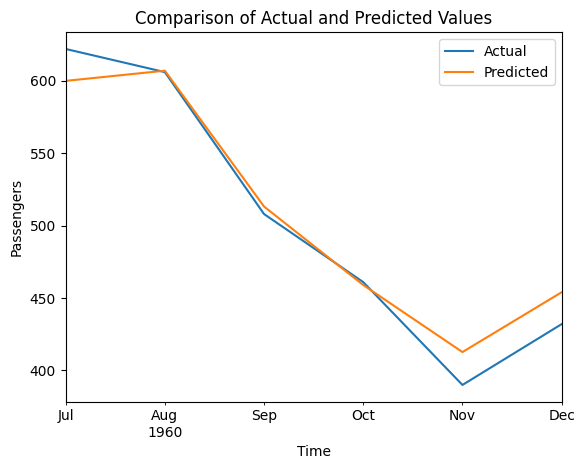

In [7]:
import matplotlib.pyplot as plt

# Get the predicted values from the ensemble forecast
predicted_values = selector.forecast(air_pass_ts_test.time_stamps)[0].to_pd()

# Create a dataframe to compare the predicted values with the actual values
comparison_df = pd.DataFrame({'Actual': air_pass_ts_test.to_pd()['Passengers'], 'Predicted': predicted_values['Passengers']})

# Plot the comparison dataframe
comparison_df.plot()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()
